This notebook investiates the feature importance of the final model.

# Setup

## Basic Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt #for displaying plots
import pandas as pd
import seaborn as sns
import tensorflow as tf

from keras.layers import *
from keras.models import Sequential
from keras.models import Model
from keras.optimizers import *
from keras.callbacks import *
from keras import regularizers
from keras.utils import plot_model

from tensorflow.keras.saving import register_keras_serializable

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import datetime
import random
import properscoring as ps

from scipy.stats import norm
from scikeras.wrappers import KerasRegressor

import xgboost
import pydot
import graphviz

from keras.models import load_model
from sklearn.multioutput import MultiOutputRegressor
import pickle

from sklearn.model_selection import ParameterGrid
from pathlib import Path
import joblib
import shap

In [2]:
# setting a seed to ensure reproducability and consistency
random.seed(16)
np.random.seed(16)
tf.random.set_seed(16)

In [ ]:
# Change Working Directory
os.chdir("..")
print(os.getcwd()) # print current working directory

In [ ]:
plt.rcParams.update({'font.size': 14})

In [ ]:
X_train = pd.read_pickle(r"data\X_train_final.pkl")
X_valid = pd.read_pickle(r"data\X_valid_final.pkl")
X_test = pd.read_pickle(r"data\X_test_final.pkl")

y_train = pd.read_pickle(r"data\y_train_final.pkl")
y_valid = pd.read_pickle(r"data\y_valid_final.pkl")
y_test = pd.read_pickle(r"data\y_test_final.pkl")


In [ ]:
base_path_plots = Path(r"Figures\(16) Feature_Importance_Final_Model")

In [5]:
X_train.head()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
0,-0.039776,-0.397192,0,1,2,1.0,0.0,0.0,0.0,-0.218119,-0.031329,0
1,0.244625,-0.397192,0,1,3,1.0,0.0,0.0,0.0,-0.324284,-0.458165,0
2,0.381694,-0.371451,0,1,4,1.0,0.0,0.0,0.0,-1.076810,0.254435,0
3,1.300863,-0.397192,0,0,5,1.0,0.0,0.0,0.0,-0.405469,1.357699,0
4,0.745990,0.555250,0,0,6,1.0,0.0,0.0,0.0,0.297096,0.059103,0


In [6]:
X_valid.tail()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
359,-1.064496,-0.397192,0,1,1,0.0,0.0,0.0,1.0,-0.258711,-0.353265,1
360,-0.478837,-0.397192,0,1,2,0.0,0.0,0.0,1.0,1.087091,-0.823509,1
361,-0.104279,0.143383,0,1,3,0.0,0.0,0.0,1.0,2.276769,-0.913940,1
362,-0.691404,0.169125,0,1,4,0.0,0.0,0.0,1.0,-0.674006,-0.508807,1
363,0.541485,-0.397192,0,0,5,0.0,0.0,0.0,1.0,1.564836,-0.201340,1


In [7]:
y_test.head()

0    1160.0
1    2996.0
2    3635.0
3    3265.0
4    3751.0
Name: bike_count, dtype: float64

In [8]:
X_train.shape, X_valid.shape, X_test.shape

((3161, 12), (364, 12), (390, 12))

In [9]:
y_train.shape, y_valid.shape, y_test.shape

((3161,), (364,), (390,))

In [10]:
y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [11]:
y_train.shape, y_valid.shape, y_test.shape

((3161,), (364,), (390,))

In [12]:
X_train.isna().sum()

temperature                 0
precipitation               0
public_holiday_indicator    0
is_workday                  0
day_of_week                 0
spring                      0
summer                      0
autumn                      0
winter                      0
windspeed                   0
sun                         0
school_holiday_indicator    0
dtype: int64

In [13]:
X_train.dtypes

temperature                 float64
precipitation               float64
public_holiday_indicator      int64
is_workday                    int64
day_of_week                   int64
spring                      float64
summer                      float64
autumn                      float64
winter                      float64
windspeed                   float64
sun                         float64
school_holiday_indicator      int64
dtype: object

In [14]:
X_train.describe()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
count,3.161000e+03,3.161000e+03,3161.000000,3161.000000,3161.000000,3161.000000,3161.000000,3161.000000,3161.000000,3.161000e+03,3.161000e+03,3161.000000
mean,4.450726e-16,3.708939e-17,0.033534,0.684910,3.001898,0.243277,0.259412,0.259095,0.238216,4.832859e-17,4.720467e-17,0.232521
std,1.000158e+00,1.000158e+00,0.180054,0.464625,2.001106,0.429129,0.438381,0.438207,0.426059,1.000158e+00,1.000158e+00,0.422506
min,-2.660948e+00,-3.971923e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.513961e+00,-1.094803e+00,0.000000
25%,-7.932892e-01,-3.971923e-01,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-7.364558e-01,-9.899026e-01,0.000000
50%,-9.270793e-04,-3.971923e-01,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,-2.056287e-01,-2.085744e-01,0.000000
75%,7.907021e-01,-1.140338e-01,0.000000,1.000000,5.000000,0.000000,1.000000,1.000000,0.000000,4.969366e-01,8.585175e-01,0.000000
max,2.566737e+00,1.461021e+01,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,4.952762e+00,2.193287e+00,1.000000


## Functions

In [15]:
def add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, col_name):
    
    X_train_num[col_name] = X_train[col_name]
    X_valid_num[col_name] = X_valid[col_name]
    X_test_num[col_name] = X_test[col_name]
    
    return X_train_num, X_valid_num, X_test_num

In [16]:
def crps_normal_cost_function(y_true, y_pred, tensor=True):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
    # get rid of axis 1
    if tensor:
        y_true = y_true[:, 0]
    
    # Split input
    mu = y_pred[:, 0]
    var = tf.square(y_pred[:, 1]) # Ensure standard deviation is positive
    sigma = tf.sqrt(var)  
    #sigma = y_pred[:, 1]

    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / tf.sqrt(2.0 * np.pi) * tf.exp(-tf.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / tf.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / tf.sqrt(np.pi))
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps) if tensor else crps

In [17]:
def crps_normal_cost_function_v2(y_true, y_pred, tensor=True):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
    # get rid of axis 1
    if tensor:
        y_true = y_true[:, 0]

    # Split input
    mu = y_pred[:, 0]
    sigma = tf.math.softplus(y_pred[:, 1])  # Apply softplus to ensure positive std
    #sigma = y_pred[:, 1]

    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / tf.sqrt(2.0 * np.pi) * tf.exp(-tf.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / tf.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / tf.sqrt(np.pi))
    
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps) if tensor else crps

In [18]:
def predict_and_calculate_mean_crps(model, X_test = X_test, y_test = y_test, print_predicted_mean_std = False):
    """Make predictions on test data and calculate mean CRPS.

    Args:
        model: Trained model
        X_test: Test data
        y_test: True values
        print_predicted_mean_std: Boolean to print predicted mean and std

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
     
    predicted_mean_std = model.predict(X_test)
    if print_predicted_mean_std:
        print(predicted_mean_std)
    
    predicted_mean = predicted_mean_std[:, 0]
    predicted_std = predicted_mean_std[:, 1]
    crps_values = ps.crps_gaussian(y_test, mu=predicted_mean, sig=predicted_std)

    mean_crps = np.mean(crps_values)
    print(f"\nMean CRPS: { mean_crps }")


    return mean_crps, predicted_mean_std, crps_values

In [19]:
def compile_and_fit_model(model, X_train = X_train, y_train = y_train, X_valid = X_valid, y_valid = y_valid,  pat=5, lr=1e-3, loss_function = crps_normal_cost_function, epochs = 100, batch_size = 10):
    """Compile and fit a model on training data.

    Args:
        model: model to be trained
        X_train: Training data
        y_train: Training targets
        X_valid: Validation data
        y_valid: Validation targets
        pat: Patience for early stopping
        lr: Learning rate
        loss_function: Loss function
        epochs: Number of epochs
        batch_size: Batch size

    Returns:
        model: Trained model
    """

    #print some information about the model
    print('Model information:\n\nCallbacks: EarlyStopping (patience: ' + str(pat) + '), Learning Rate (Reduce on Plateau, patience: ' + str(pat) + ')\nBatch size: ' + str(batch_size) + '\nEpochs: ' + str(epochs) + '\n')
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=pat, 
                                                      restore_best_weights=True)
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.2,
                                                     patience = pat,
                                                     min_lr=0 )
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss_function)

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=[early_stopping, reduce_lr])

    return model, history

In [20]:
def plot_loss(history):
    """Plot training and validation loss.

    Args:
        history: History object
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [21]:
def process_model(model, X_train = X_train, y_train = y_train, X_valid = X_valid, y_valid = y_valid,  X_test = X_test, y_test = y_test, pat=5, lr=1e-3, loss_function = crps_normal_cost_function, epochs = 100, batch_size = 10, print_predicted_mean_std = False, plot_loss_flag = True):
    """Compile, fit and evaluate a model.

    Args:
        model: model to be trained
        X_train: Training data
        y_train: Training targets
        X_valid: Validation data
        y_valid: Validation targets
        X_test: Test data
        y_test: Test targets
        pat: Patience for early stopping
        lr: Learning rate
        loss_function: Loss function
        epochs: Number of epochs
        batch_size: Batch size
        print_predicted_mean_std: Boolean to print predicted mean and std
"""

    model, history = compile_and_fit_model(model, X_train, y_train, X_valid, y_valid,  pat, lr, loss_function, epochs, batch_size)

    mean_crps, predicted_mean_std = predict_and_calculate_mean_crps(model, X_test, y_test, print_predicted_mean_std)

    if plot_loss_flag:
        plot_loss(history)

    return model, mean_crps, history, predicted_mean_std

# Feature Importances of final GridSearchCV model

## Loading the Grid Search CV model

In [22]:
@register_keras_serializable(package="Custom", name="crps_normal_cost_function")
def crps_normal_cost_function_v3(y_true, y_pred, tensor=True):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
    #print("y_true shape2: ", y_true.shape)
    # Split input
    mu = y_pred[:, 0]
    sigma = tf.math.softplus(y_pred[:, 1])  # Apply softplus to ensure positive std
    #sigma = y_pred[:, 1]
    
    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / tf.sqrt(2.0 * np.pi) * tf.exp(-tf.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / tf.sqrt(2.0)))
    
     # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / tf.sqrt(np.pi))   
    
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps) if tensor else crps

In [23]:
@register_keras_serializable(package="Custom", name="crps_loss_function_wrapper")  
def crps_loss_function_wrapper(y_true, y_pred, tensor=True):
    """Wrapper for CRPS loss function.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch
    """
    
    if isinstance(y_pred, (pd.DataFrame, pd.Series)):
       y_pred = tf.convert_to_tensor(y_pred.values)

    if isinstance(y_true, (pd.DataFrame, pd.Series)):
        y_true = tf.convert_to_tensor(y_true.values, dtype=tf.float32)
        
    y_pred_reshaped = y_pred.reshape(-1, 2) #Keras Regressor flattens the values so they need to be reshaped

    crps = crps_normal_cost_function_v3(y_true, y_pred_reshaped, tensor)

    crps = crps.numpy()
    
    return crps

In [ ]:
base_path = Path(r"hyperparameter_tuning_results\Final_GridSearch")

In [25]:
file_name_grid_search = "grid_search_tuned_v3.pkl"
file_path_grid_search = base_path / file_name_grid_search

In [26]:
loaded_grid_search_tuned = joblib.load(str(file_path_grid_search))

In [27]:
model = loaded_grid_search_tuned.best_estimator_.model_

In [28]:
mean_crps, predicted_mean_std, crps_values = predict_and_calculate_mean_crps(model, X_test, y_test, print_predicted_mean_std = False)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Mean CRPS: 289.1277783206882


In [29]:
cv_results = pd.DataFrame(loaded_grid_search_tuned.cv_results_)

In [30]:
cv_results['mean_test_score'] = cv_results['mean_test_score'] *-1

In [31]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_model__dropout_rate,param_model__n_blocks,param_model__n_neurons,param_model__reg_value,param_optimizer__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,48.223752,1.709674,0.176028,0.007099,32,0.25,2,256,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0.25...",-430.748718,-372.753448,-468.966064,424.156077,39.554301,2
1,81.853206,7.645734,0.350750,0.097082,32,0.25,4,256,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0.25...",-401.316406,-358.324493,-474.933044,411.524648,48.149383,1
2,85.200021,15.338510,0.236923,0.012039,32,0.25,5,256,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0.25...",-420.538239,-361.145172,-494.574432,425.419281,54.581501,3
3,83.479662,5.110902,0.269961,0.022501,32,0.25,6,256,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0.25...",-433.919098,-385.169983,-577.519043,465.536041,81.646652,4


## Permutation Importance

In [32]:
def crps_scorer(estimator, X, y):
    """
    A wrapper for crps_normal_cost_function to work with Scikit-learn's scoring API.
    
    Args:
        estimator: Trained model with a `predict` method.
        X: Features (numpy array or pandas DataFrame).
        y: True target values (numpy array or pandas Series).

    Returns:
        Scalar score (negative CRPS for minimization).
    """
    # Generate predictions using the model
    y_pred = estimator.predict(X)  # Assuming [mean, std] output
    # Ensure y is a NumPy array
    y_true = y.to_numpy() if hasattr(y, "to_numpy") else y
    # Call the CRPS function (use tensor=False to avoid TensorFlow tensors)
    crps_values = crps_normal_cost_function(y_true, y_pred, tensor=False)
    # Return the mean CRPS as a negative value for minimization
    return -np.mean(crps_values)  # Negating for Scikit-learn's convention

In [33]:
result_baseline_model = permutation_importance(model, X_test, y_test, scoring=crps_scorer)
importances_baseline_model = result_baseline_model.importances_mean
importance_stds_baseline_model = result_baseline_model.importances_std

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

In [34]:
feature_names = X_test.columns

importance_df_baseline_model = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances_baseline_model,
    'Std': importance_stds_baseline_model
}).sort_values(by='Importance', ascending=False)

print(importance_df_baseline_model)

                     Feature  Importance        Std
4                day_of_week  498.059814  25.197891
0                temperature  271.968323  13.370695
7                     autumn  252.644440  18.465540
5                     spring  217.557526  18.710896
6                     summer  210.816498  11.515367
8                     winter  208.122650  10.953131
3                 is_workday  183.499176  15.756657
11  school_holiday_indicator  116.506493   7.146584
2   public_holiday_indicator  108.822731   5.612630
1              precipitation   91.880775  10.134636
9                  windspeed   19.612146   1.615842
10                       sun   13.100952   1.398855


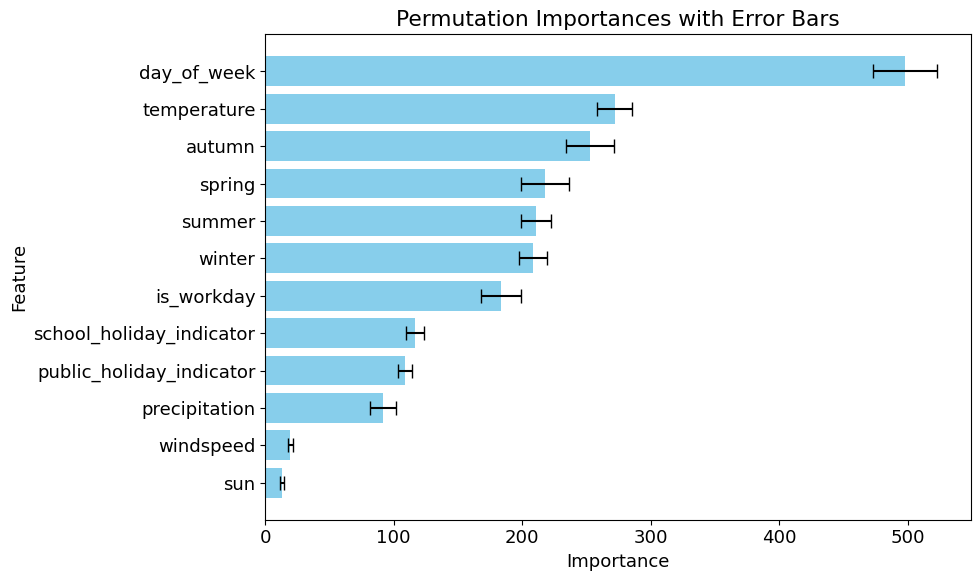

In [ ]:
# Plot with error bars
feature_importance = plt.figure(figsize=(10, 6))
plt.barh( importance_df_baseline_model['Feature'], importance_df_baseline_model['Importance'], xerr=importance_df_baseline_model['Std'], color='skyblue', capsize=5 )
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Permutation Importances with Error Bars')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
feature_importance.figure.savefig(base_path_plots / "permutation_importance.png")

## SHAP

In [36]:
shap.initjs()

In [37]:
background_data = shap.sample(X_train, 100)

In [38]:
explainer_sample = shap.KernelExplainer(model.predict, background_data)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [39]:
shap_values = explainer_sample.shap_values(X_test, nsamples=100)

  0%|          | 0/390 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
313/313 ━━━━━━

### Mu

In [40]:
shap_values_mu = shap_values[:, :, 0]

In [41]:
shap_values_mu_df = pd.DataFrame(shap_values_mu, columns=X_test.columns)

In [ ]:
shap_values_mu_df.to_csv(r"data\shap_values_df.csv", index=False)

In [ ]:
shap_values_loaded_df = pd.read_csv(r"data\shap_values_df.csv")

In [44]:
shap_values_loaded_df.head()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
0,143.192753,41.042541,-1329.669739,-438.000719,-920.790844,-162.299225,-235.201354,-332.351318,108.910157,0.000000,0.000000,-431.696966
1,0.000000,-109.480068,130.833631,206.248866,214.576193,-192.489017,-257.351246,-353.853416,-467.219647,0.000000,-158.636496,-976.488020
2,-306.361622,181.866314,112.174962,269.649616,449.839297,-142.785148,-233.363953,-327.539311,-472.343104,61.160831,0.000000,-920.487181
3,-69.541892,128.722585,139.610295,279.597840,499.577105,-205.194125,-211.562854,-320.410356,-312.946207,-334.824791,-250.917295,-887.384320
4,63.846275,131.850774,123.536377,236.416663,498.780423,-181.505072,-270.649546,-333.563317,-344.266768,-107.505029,-224.477756,-901.669903


In [45]:
shap_values_mu_loaded = shap_values_loaded_df.to_numpy()

In [46]:
shap_values_mu_loaded.shape

(390, 12)

In [47]:
shap_values_mu_explanation = shap.Explanation(values=shap_values_mu_loaded, data=X_test)
shap_values_mu_explanation

.values =
array([[  143.19275284,    41.04254054, -1329.66973889, ...,
            0.        ,     0.        ,  -431.69696639],
       [    0.        ,  -109.48006826,   130.83363113, ...,
            0.        ,  -158.63649619,  -976.48802021],
       [ -306.36162216,   181.86631425,   112.17496163, ...,
           61.16083097,     0.        ,  -920.48718147],
       ...,
       [  -58.97789407,   106.16934528,   159.46875804, ...,
         -222.25997891,   -61.89824986,   193.38250358],
       [  157.67733284,  -115.24474386,   140.34804242, ...,
         -301.71136471,  -193.1401243 ,   131.98067916],
       [  -37.65239769,     0.        ,   111.00631551, ...,
            0.        ,   -61.54122911,   183.82263897]])

.data =
     temperature  precipitation  public_holiday_indicator  is_workday  \
0       0.156666      -0.397192                         1           0   
1      -0.267002       0.014675                         0           1   
2      -0.832871      -0.397192          

In [48]:
shap_values_loaded_df

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
0,143.192753,41.042541,-1329.669739,-438.000719,-920.790844,-162.299225,-235.201354,-332.351318,108.910157,0.000000,0.000000,-431.696966
1,0.000000,-109.480068,130.833631,206.248866,214.576193,-192.489017,-257.351246,-353.853416,-467.219647,0.000000,-158.636496,-976.488020
2,-306.361622,181.866314,112.174962,269.649616,449.839297,-142.785148,-233.363953,-327.539311,-472.343104,61.160831,0.000000,-920.487181
3,-69.541892,128.722585,139.610295,279.597840,499.577105,-205.194125,-211.562854,-320.410356,-312.946207,-334.824791,-250.917295,-887.384320
4,63.846275,131.850774,123.536377,236.416663,498.780423,-181.505072,-270.649546,-333.563317,-344.266768,-107.505029,-224.477756,-901.669903
...,...,...,...,...,...,...,...,...,...,...,...,...
385,-822.824104,140.862935,0.000000,-504.848154,-1579.728786,-202.174510,-332.798184,-454.602198,364.897140,85.008690,0.000000,76.065723
386,-135.098992,-496.392323,104.788062,276.241972,359.744251,-217.386385,-228.711669,-307.195602,-57.390033,-171.071583,-274.049677,202.422768
387,-58.977894,106.169345,159.468758,324.340641,545.590424,-148.242053,-237.037400,-220.602919,-47.829752,-222.259979,-61.898250,193.382504
388,157.677333,-115.244744,140.348042,331.804585,595.844817,-176.522419,-225.950201,-245.534049,-114.935457,-301.711365,-193.140124,131.980679


In [49]:
shap_values_mu_explanation.feature_names = X_test.columns

In [50]:
X_test.head()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
0,0.156666,-0.397192,1,0,6,0.0,0.0,0.0,1.0,-0.146301,-0.385820,1
1,-0.267002,0.014675,0,1,0,0.0,0.0,0.0,1.0,-0.196261,-0.736694,1
2,-0.832871,-0.397192,0,1,1,0.0,0.0,0.0,1.0,-1.011237,0.160386,1
3,-0.452449,-0.319967,0,1,2,0.0,0.0,0.0,1.0,3.104234,-1.094803,1
4,-0.179777,-0.319967,0,1,3,0.0,0.0,0.0,1.0,1.486773,-1.015223,1


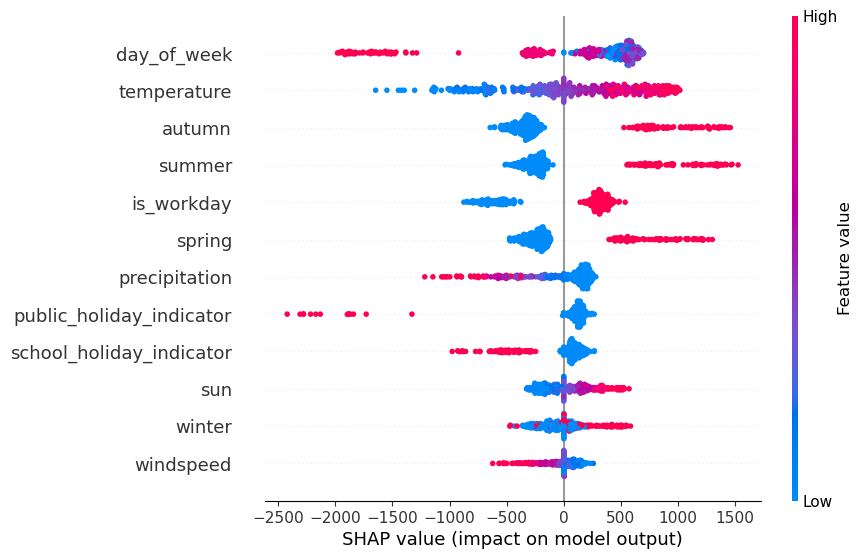

<Figure size 640x480 with 0 Axes>

In [51]:
beeswarm_plot = shap.plots.beeswarm(shap_values_mu_explanation, max_display=15)
plt.tight_layout()
plt.show()
plt.close()

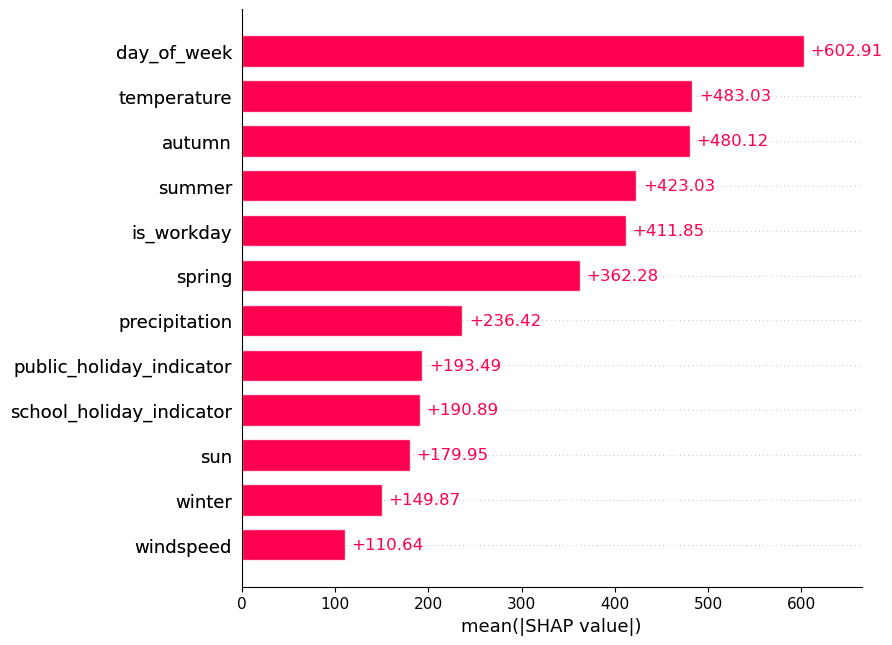

<Figure size 640x480 with 0 Axes>

In [52]:
shap.plots.bar(shap_values_mu_explanation, max_display=15 )
plt.tight_layout()
plt.show()
plt.close()

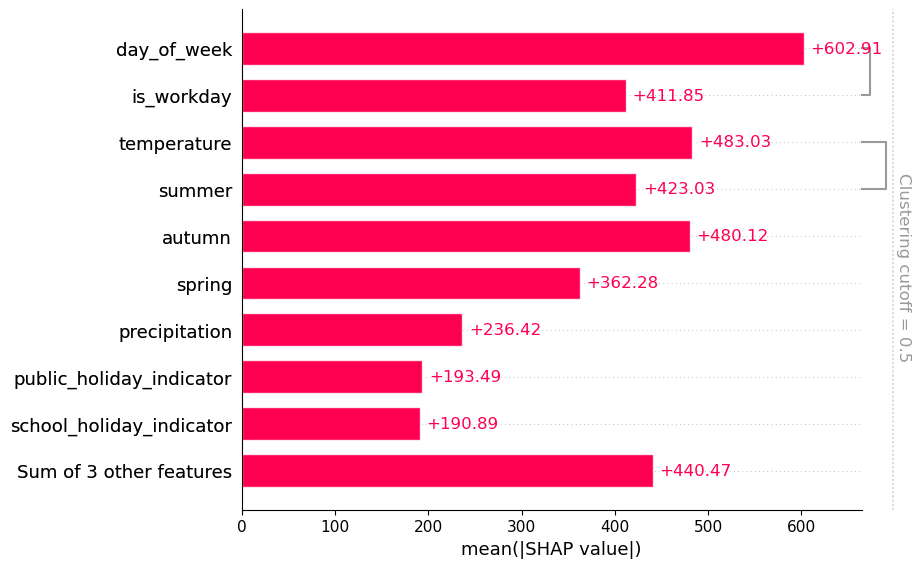

<Figure size 640x480 with 0 Axes>

In [53]:
clustering = shap.utils.hclust(X_train, y_train)
shap.plots.bar(shap_values_mu_explanation, clustering=clustering)
plt.tight_layout()
plt.show()
plt.close()

### Sigma

In [54]:
shap_values_sigma = shap_values[:, :, 1]

In [55]:
shap_values_sigma_df = pd.DataFrame(shap_values_sigma, columns=X_test.columns)

In [ ]:
shap_values_sigma_df.to_csv(r"data\shap_values_df_sigma.csv", index=False)

In [ ]:
shap_values_loaded_df_sigma = pd.read_csv(r"data\shap_values_df_sigma.csv")

In [58]:
shap_values_loaded_df_sigma.head()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
0,0.000000,0.000000,-196.192870,-57.308360,-89.160176,-19.357640,-26.776493,-35.142337,0.000000,0.000000,0.000000,-54.815311
1,0.000000,-13.998991,16.757244,29.098578,18.927669,-24.480044,-32.954833,-44.065088,-67.893198,0.000000,-22.467896,-129.761683
2,-39.784973,24.005206,14.029197,37.838253,47.396013,-17.652973,-30.678746,-41.308728,-67.534021,8.524987,1.992021,-124.061908
3,-10.176350,17.390925,17.389616,38.335449,54.321979,-25.169489,-27.275008,-39.841269,-46.914448,-43.245669,-34.198510,-117.648550
4,7.058601,17.878509,15.097742,33.689819,52.479526,-22.072002,-33.833577,-41.564572,-51.924972,-14.619092,-31.163185,-119.868272


In [59]:
shap_values_sigma_loaded = shap_values_loaded_df_sigma.to_numpy()

In [60]:
shap_values_sigma_loaded.shape

(390, 12)

In [61]:
shap_values_sigma_explanation = shap.Explanation(values=shap_values_sigma_loaded, data=X_test)
shap_values_sigma_explanation

.values =
array([[   0.        ,    0.        , -196.19287048, ...,    0.        ,
           0.        ,  -54.81531115],
       [   0.        ,  -13.99899073,   16.75724448, ...,    0.        ,
         -22.46789615, -129.76168269],
       [ -39.78497304,   24.00520608,   14.02919687, ...,    8.52498741,
           1.99202085, -124.06190781],
       ...,
       [  -8.05452031,   14.03215236,   20.10018409, ...,  -29.22801215,
          -9.13332259,   25.30759372],
       [  19.60985583,  -15.01058003,   17.93559025, ...,  -39.64524247,
         -27.08910003,   17.70221297],
       [  -5.07409077,    0.        ,   15.05947685, ...,    0.        ,
          -8.36030596,   23.60353413]])

.data =
     temperature  precipitation  public_holiday_indicator  is_workday  \
0       0.156666      -0.397192                         1           0   
1      -0.267002       0.014675                         0           1   
2      -0.832871      -0.397192                         0           1   
3   

In [62]:
shap_values_sigma_explanation.feature_names = X_test.columns

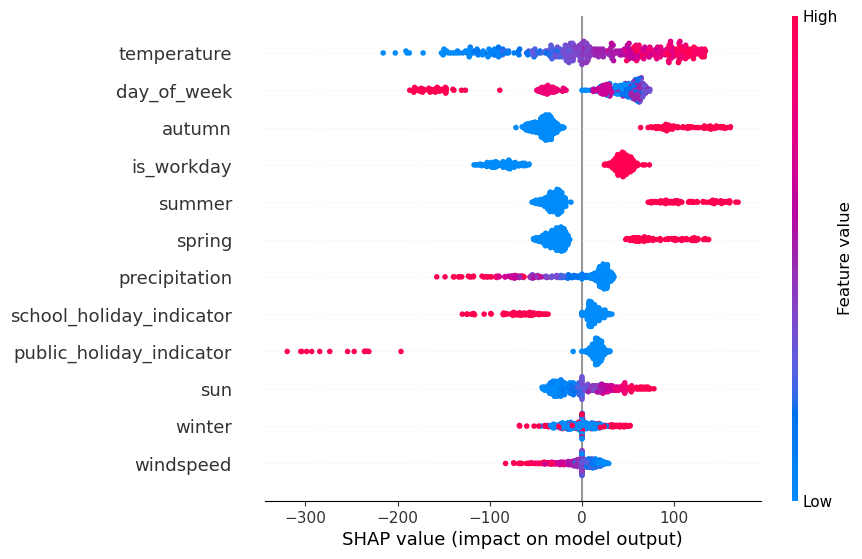

<Figure size 640x480 with 0 Axes>

In [63]:
beeswarm_plot = shap.plots.beeswarm(shap_values_sigma_explanation, max_display=15)
plt.tight_layout()
plt.show()
plt.close()

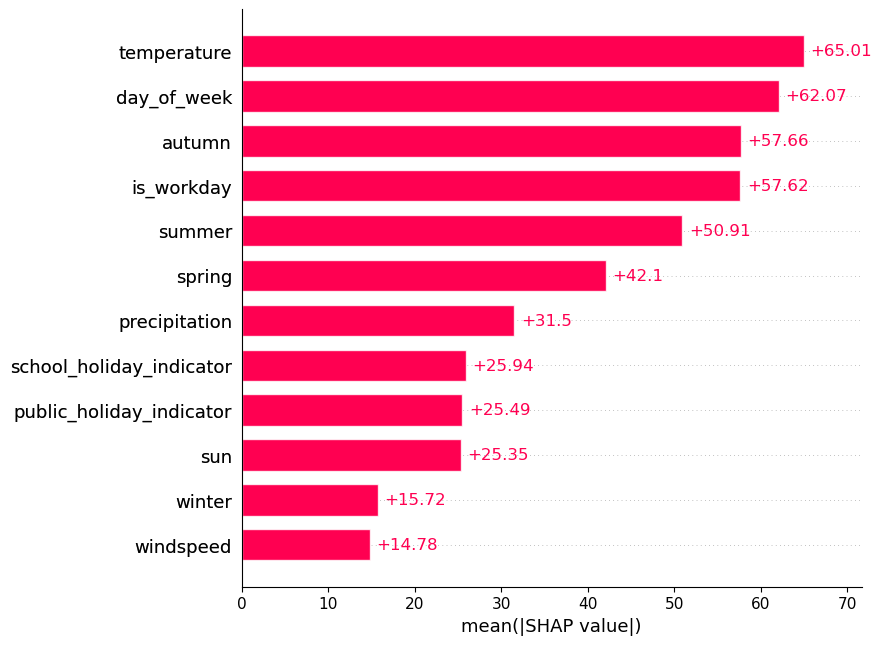

<Figure size 640x480 with 0 Axes>

In [64]:
shap.plots.bar(shap_values_sigma_explanation, max_display=15 )
plt.tight_layout()
plt.show()
plt.close()

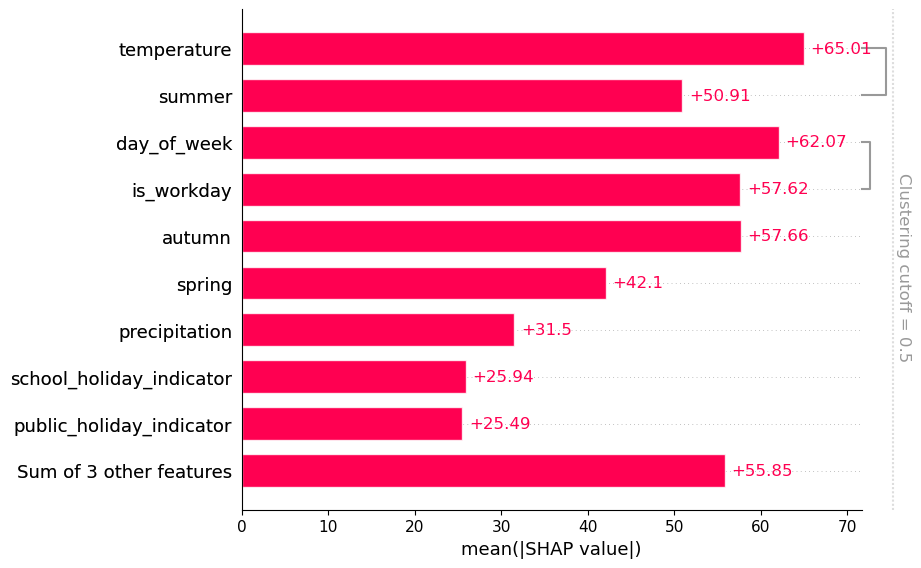

<Figure size 640x480 with 0 Axes>

In [65]:
clustering = shap.utils.hclust(X_train, y_train)
shap.plots.bar(shap_values_sigma_explanation, clustering=clustering)
plt.tight_layout()
plt.show()
plt.close()